In [3]:
import os
from pathlib import Path

import h3
import numpy as np
import pandas as pd
import geopandas as gpd

from shapely.geometry import Point, Polygon, GeometryCollection
from shapely.ops import unary_union

pd.set_option("display.max_columns", None)

np.random.seed(42)

In [4]:
SCRAPED_DATA_DIR = Path(os.getcwd()).parent.parent / "avrora-scraper" / "data"
GEOJSON_DATA_DIR = Path(os.getcwd()).parent / "data"

### Read your JSON (or CSV) of existing stores.
Here we assume a JSON array where each entry has "latitude" and "longitude" as strings.

In [5]:
df_full = pd.read_json(SCRAPED_DATA_DIR / "store_locations.json")  # or pd.read_csv(...)
# Convert lat/lon columns to float:
df_full["lat"] = df_full["latitude"].astype(float)
df_full["lon"] = df_full["longitude"].astype(float)

In [6]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1698 entries, 0 to 1697
Data columns (total 34 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   store_location_id        1698 non-null   int64  
 1   company_id               1698 non-null   int64  
 2   position                 1698 non-null   int64  
 3   country                  1698 non-null   object 
 4   state                    1698 non-null   object 
 5   latitude                 1698 non-null   float64
 6   longitude                1698 non-null   float64
 7   localization             1698 non-null   object 
 8   status                   1698 non-null   object 
 9   main_destination_id      1696 non-null   float64
 10  pickup_destinations_ids  1698 non-null   int64  
 11  shopNumber               1698 non-null   int64  
 12  old_slid                 1698 non-null   int64  
 13  is_warehouse             1698 non-null   object 
 14  city_id                 

In [7]:
USEFULL_COLUMNS = [
    'store_location_id',
    'lat', 'lon', 
    'city', 'city_id',
    'shopFormat', 'is_warehouse'
] # Adjust this list based on your needs

df = df_full[USEFULL_COLUMNS]

In [8]:
df.head()

,store_location_id,lat,lon,city,city_id,shopFormat,is_warehouse
0,2,49.191355,26.835622,Ярмолинці,27468,СТАНДАРТ,N
1,3,50.470180,34.960030,Тростянець,24675,СТАНДАРТ,N
2,4,49.574571,34.507404,Полтава,19657,СТАНДАРТ,N
3,5,50.746597,33.489347,Ромни,21074,СТАНДАРТ,N
4,6,51.493929,31.292076,Чернігів,26230,СТАНДАРТ,N


In [9]:
df.shopFormat.value_counts()

shopFormat
СТАНДАРТ    1473
МАКСІ        223
               2
Name: count, dtype: int64

In [10]:
df.is_warehouse.value_counts()

is_warehouse
N    1698
Name: count, dtype: int64

In [11]:
df.city.value_counts().head(30)

city
Київ                152
Дніпро               67
Харків               67
Кривий Ріг           52
Запоріжжя            42
Одеса                37
Полтава              36
Миколаїв             32
Львів                25
Кропивницький        23
Суми                 23
Чернігів             23
Кам'янське           22
Кременчук            20
Черкаси              20
Луцьк                19
Житомир              19
Хмельницький         17
Вінниця              16
Рівне                14
Івано-Франківськ     13
Херсон               12
Біла Церква          12
Бровари              11
Павлоград            11
Ужгород              11
Чернівці             11
Тернопіль            11
Ірпінь                9
Олександрія           9
Name: count, dtype: int64

### Turn into a GeoDataFrame.

In [12]:
# ── 2. Choose H3 resolution and compute each index ─────────────────────────────
HEXAGON_RESOLUTION = 8 # https://h3geo.org/docs/core-library/restable/
df["h3_index"] = df.apply(
    lambda row: h3.latlng_to_cell(row["lat"], row["lon"], HEXAGON_RESOLUTION),
    axis=1
)

/var/folders/2w/kt2rskqn19s6w8jmzjqdj2v00000gp/T/ipykernel_11087/730877457.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["h3_index"] = df.apply(


In [13]:
# ── 3. Build the hexagon polygons (swap lat/lon → lon/lat!) ────────────────────
df["hex_poly"] = df["h3_index"].apply(
    lambda h: Polygon([(lng, lat) for lat, lng in h3.cell_to_boundary(h)])
)

# ── 4. Build a Point for each store location ──────────────────────────────────
df["store_point"] = df.apply(
    lambda row: Point(row["lon"], row["lat"]),
    axis=1
)

/var/folders/2w/kt2rskqn19s6w8jmzjqdj2v00000gp/T/ipykernel_11087/4093688464.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["hex_poly"] = df["h3_index"].apply(
/var/folders/2w/kt2rskqn19s6w8jmzjqdj2v00000gp/T/ipykernel_11087/4093688464.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["store_point"] = df.apply(


In [14]:
# ── 6. Create a GeoDataFrame whose “geometry” is that collection ──────────────
gdf = gpd.GeoDataFrame(
    df,
    geometry="hex_poly",
    crs="EPSG:4326"
)

# # ── 7. Export to GeoJSON ───────────────────────────────────────────────────────
# (A) Export hexagons only:
gdf_hex = gpd.GeoDataFrame(df, geometry="hex_poly", crs="EPSG:4326")
gdf_hex.to_file(GEOJSON_DATA_DIR / f"positive_store_hexagons_{HEXAGON_RESOLUTION}_resolution.geojson", driver="GeoJSON")

# (B) Export points only:
gdf_pt = gpd.GeoDataFrame(df, geometry="store_point", crs="EPSG:4326")
gdf_pt.to_file(GEOJSON_DATA_DIR / f"positive_store_points_{HEXAGON_RESOLUTION}_resolution.geojson", driver="GeoJSON")

In [38]:
gdf_pt_odesa = gdf_pt[gdf_pt["city"] == "Харків"].copy()
gdf_pt_odesa = gdf_pt_odesa.set_geometry(gdf_pt_odesa["store_point"])
gdf_pt_odesa.to_file("/Users/n.protsiv/private/ucu-ml-2025/map-proto/geodata/harkiv/harkiv-avrora-locations.geojson", driver="GeoJSON")

## Build city boundaries from existing stores (Optional, example of Lviv for visualization)

In [15]:
gdf_lviv = gdf_hex[gdf["city"] == "Львів"].copy()
gdf_lviv.head(1)

,store_location_id,lat,lon,city,city_id,shopFormat,is_warehouse,h3_index,hex_poly,store_point
518,660,49.79701,24.05414,Львів,13073,СТАНДАРТ,N,881e7689bbfffff,"POLYGON ((24.04688 49.80108, 24.04407 49.79686...",POINT (24.05414 49.79701)


In [16]:
# Suppose stores_this_city is a GeoSeries of Points (EPSG:4326).
# 1) Dissolve into a single MultiPoint:
multi = unary_union(gdf_lviv.geometry.tolist())
# 2) Convex hull around those points (in EPSG:4326)
city_approx_poly = multi.convex_hull
# 3) Optionally buffer it by some kilometers to get a “urban area”:
city_approx_poly_m = gpd.GeoSeries([city_approx_poly], crs="EPSG:4326").to_crs("EPSG:3857")
city_approx_poly_m = city_approx_poly_m.buffer(4000)  # 2 km outward
city_approx_poly = city_approx_poly_m.to_crs("EPSG:4326").iloc[0]

In [17]:
# save city_approx_poly to GeoJSON
gpd.GeoDataFrame(geometry=[city_approx_poly], crs="EPSG:4326").to_file(
    GEOJSON_DATA_DIR / "lviv_city_approx.geojson", driver="GeoJSON"
)

In [18]:
def get_city_approx_polygons(gdf_hex, city, buffer_km):
    gdf_filtered = gdf_hex[gdf_hex["city"] == city].copy()
    if gdf_filtered.empty:
        return None
    multi = unary_union(gdf_filtered.geometry.tolist())
    city_approx_poly = multi.convex_hull
    city_approx_poly_m = gpd.GeoSeries([city_approx_poly], crs="EPSG:4326").to_crs("EPSG:3857")
    city_approx_poly_m = city_approx_poly_m.buffer(buffer_km * 1000)  # Convert km to m
    city_approx_poly = city_approx_poly_m.to_crs("EPSG:4326").iloc[0]
    
    return city_approx_poly

## Create “approximate city” polygons from store points

so we can sample negative examples within city boundaries

In [19]:
# We’ll create a DataFrame → each row = one city_id and its approx polygon.
city_polys = []

CITY_BUFFER_METERS = 3000  # e.g. 3 km buffer around each city

# Loop over each unique city_id to build a convex‐hull + buffer.
for city_id, group in gdf.groupby("city_id"):
    # Take all point‐geometries for this city (EPSG:4326).
    pts = group.geometry.tolist()
    if len(pts) == 1:
        # If there’s only one point, a convex hull is just that point.
        base_geom = pts[0]
    else:
        # Build a single MultiPoint and then its convex hull.
        base_geom = unary_union(pts).convex_hull  # still in EPSG:4326

    # Reproject to a metric CRS (EPSG:3857) so we can buffer in meters.
    geo = gpd.GeoSeries([base_geom], crs="EPSG:4326")
    geo_m = geo.to_crs("EPSG:3857")

    # Buffer by CITY_BUFFER_METERS
    buffered_m = geo_m.buffer(CITY_BUFFER_METERS)
    # Reproject the buffered hull back to EPSG:4326.
    buffered_wgs = buffered_m.to_crs("EPSG:4326").iloc[0]
    city = group.iloc[0]["city"]  # Get the city name from the first row.
    city_polys.append({"city_id": city_id, "city": city, "geometry": buffered_wgs})

# Build a GeoDataFrame where each row is an approximate “city boundary” in EPSG:4326.
city_approx_gdf = gpd.GeoDataFrame(city_polys, crs="EPSG:4326")

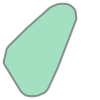

In [25]:
city_approx_gdf[city_approx_gdf['city'] == 'Одеса'].geometry.iloc[0]

In [32]:
all_hexes = hexes_in_polygon(city_approx_gdf[city_approx_gdf['city'] == 'Харків'].geometry.iloc[0], HEXAGON_RESOLUTION)

In [ ]:
cand_polys = []

for h3_idx in all_hexes:
    # Build the full hexagon boundary as a Shapely Polygon in WGS84
    poly_wgs = Polygon([(lng, lat) for lat, lng in h3.cell_to_boundary(h3_idx)])
    cand_polys.append({
        "h3_index": h3_idx,
        "hex_poly": poly_wgs
    })

cand_gdf = gpd.GeoDataFrame(cand_polys, geometry="hex_poly", crs="EPSG:4326")

In [35]:
cand_gdf.head(1)

,h3_index,hex_poly
0,881196429bfffff,"POLYGON ((36.26165 50.07579, 36.2656 50.07181,..."


In [34]:
cand_gdf.to_file(GEOJSON_DATA_DIR / f"harkiv_candidate_hexagons_{HEXAGON_RESOLUTION}_resolution.geojson", driver="GeoJSON")

## Parameters for negative sampling

In [ ]:
# Rate of negatives per city (e.g. 3 we will sample 3x more negative hexes than positive ones within a city).
NEG_RATE = 4

# Minimum distance (in meters) that a negative‐hex centroid must be away from any store.
# For example, 500 meters. Adjust as needed.
MIN_DIST_METERS = 500

In [26]:
# ──────────────────────────────────────────────────────────────────────────────
# FUNCTION TO GET H3 HEXES INSIDE A CITY POLYGON AT RESOLUTION RES
# ──────────────────────────────────────────────────────────────────────────────

def hexes_in_polygon(polygon: Polygon, res: int) -> set:
    """
    Given a Shapely Polygon (in EPSG:4326), return the set of all H3 indices
    at resolution `res` whose hexagons intersect that polygon.

    Under the new h3-py API, polygon_to_cells wants:
      – `geo_boundary`: a list of [lat, lng] pairs for the exterior ring, and
      – (optionally) a list of lists of [lat, lng] pairs for any holes.
    """

    # Extract the exterior ring as a list of (lat, lng) pairs.
    #  polygon.exterior.coords yields (x, y) = (lon, lat), so we flip them.
    exterior_ring = [(lat, lng) for (lng, lat) in polygon.exterior.coords]

    holes = []
    all_cells = h3.polygon_to_cells(h3.LatLngPoly(exterior_ring, holes), res)

    return set(all_cells)

## Main loop: for each city, build negative set

In [ ]:
# First, convert your `df` of store locations into a GeoDataFrame, so we can spatial‐index easily:
stores_gdf = gpd.GeoDataFrame(
    df[["city_id", "h3_index", "lat", "lon"]],
    geometry=df["store_point"],
    crs="EPSG:4326"
)

negative_rows = []  # will collect dicts: {"city_id", "h3_index", "hex_poly"}

# To compute true metric distances, reproject to a metric CRS. We’ll pick an equal‐area / “local UTM” style.
# For simplicity, let’s reproject everything to EPSG:3857 (Pseudo‐Mercator). If your city is far north, you
# may want a suitable UTM zone, but EPSG:3857 is “good enough for a ~500m buffer check”.  
stores_gdf_m = stores_gdf.to_crs("EPSG:3857")
city_boundaries_m = city_approx_gdf.to_crs("EPSG:3857")

In [ ]:
city_approx_gdf.head(1)

,city_id,city,geometry
0,0,Краматорськ,"POLYGON ((37.56188 48.75308, 37.56487 48.75739..."


In [ ]:
for city, city_id, city_poly_wgs in city_approx_gdf[["city", "city_id", "geometry"]].itertuples(index=False):
    # Subset the store points for this city, in both WGS84 and metric.  
    stores_this_city = stores_gdf[stores_gdf["city_id"] == city_id]

    if stores_this_city.empty:
        # No positives in this city → skip or handle separately.
        continue

    # Count how many positives exist:
    n_pos = len(stores_this_city)

    # Get the city polygon in WGS84, then polyfill to get ALL candidate hex IDs.  
    # We assume city_poly_wgs is a (multipolygon/polygon) in EPSG:4326.
    all_hexes = hexes_in_polygon(city_poly_wgs, HEXAGON_RESOLUTION)

    # Build the set of “positive” store hexagons in this city.
    pos_hexes = set(stores_this_city["h3_index"].unique())

    # Remove positives from all_hexes → get initial candidate negatives.
    candidate_hexes = all_hexes.difference(pos_hexes)
    if not candidate_hexes:
        # No available hexes outside positives (rare). Skip.
        continue

    # Build a GeoDataFrame of candidate‐hex polygons (in WGS84)
    cand_polys = []
    for h3_idx in candidate_hexes:
        # Build the full hexagon boundary as a Shapely Polygon in WGS84
        poly_wgs = Polygon([(lng, lat) for lat, lng in h3.cell_to_boundary(h3_idx)])
        cand_polys.append({
            "h3_index": h3_idx,
            "hex_poly": poly_wgs
        })

    cand_gdf = gpd.GeoDataFrame(cand_polys, geometry="hex_poly", crs="EPSG:4326")

    # Reproject both candidate hexagons and store points into a metric CRS:
    cand_gdf_m = cand_gdf.to_crs("EPSG:3857")
    stores_m_city = stores_this_city.to_crs("EPSG:3857")

    # Build the unioned “no‐go” buffer around all store points (radius = MIN_DIST_METERS)
    store_buffers = stores_m_city.buffer(MIN_DIST_METERS).unary_union

    # Now filter out any candidate hexagon whose **polygon** intersects that buffer.
    # In other words, keep only those hexes where hex_poly_m.intersects(store_buffers) == False.
    mask_outside = ~cand_gdf_m.geometry.intersects(store_buffers)
    cand_filtered = cand_gdf[mask_outside]  # this is back in WGS84 (EPSG:4326)

    # cand_filtered now contains only those full‐hex polygons that are entirely
    # at least MIN_DIST_METERS away from every store, rather than just checking centroids.

    if cand_filtered.empty:
        # If every hex within city is too close to a store, skip.
        continue

    # Decide how many negatives to sample = ceil(n_pos * NEG_RATE).
    n_neg_desired = np.ceil(n_pos * NEG_RATE)
    if len(cand_filtered) < n_neg_desired:
        # If not enough candidates, just take them all. Otherwise sample randomly.
        sampled = cand_filtered.copy()
    else:
        sampled = cand_filtered.sample(n=n_neg_desired, random_state=42)

    # For each sampled hex, reconstruct its full polygon (if you want).  
    # Add to negative_rows list.
    for _, row in sampled.iterrows():
        h_index = row["h3_index"]
        poly = Polygon([(lng, lat) for lat, lng in h3.cell_to_boundary(h_index)])
        negative_rows.append({
            "city": city,
            "city_id": city_id,
            "h3_index": h_index,
            "hex_poly": poly
        })

/var/folders/2w/kt2rskqn19s6w8jmzjqdj2v00000gp/T/ipykernel_78766/605807268.py:42: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  store_buffers = stores_m_city.buffer(MIN_DIST_METERS).unary_union
/var/folders/2w/kt2rskqn19s6w8jmzjqdj2v00000gp/T/ipykernel_78766/605807268.py:42: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  store_buffers = stores_m_city.buffer(MIN_DIST_METERS).unary_union
/var/folders/2w/kt2rskqn19s6w8jmzjqdj2v00000gp/T/ipykernel_78766/605807268.py:42: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  store_buffers = stores_m_city.buffer(MIN_DIST_METERS).unary_union
/var/folders/2w/kt2rskqn19s6w8jmzjqdj2v00000gp/T/ipykernel_78766/605807268.py:42: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  store_buffers = stores_m_city.buffer(MIN_DIST_METERS).unary_un

In [ ]:
# Finally, build neg_gdf exactly as before:
neg_df = pd.DataFrame(negative_rows)
neg_gdf = gpd.GeoDataFrame(neg_df, geometry="hex_poly", crs="EPSG:4326")

In [ ]:
# Ensure both GeoDataFrames use the same CRS
neg_gdf = neg_gdf.to_crs("EPSG:4326")
gdf = gdf.to_crs("EPSG:4326")

# Create a GeoDataFrame of just the positive store hexes (unique hex polygons)
store_hexes = gdf_hex[["h3_index", "hex_poly"]].drop_duplicates(subset="h3_index")

# Use spatial join to find negative hexes that intersect with any store hex polygon
overlapping = gpd.sjoin(neg_gdf, store_hexes, how="inner", predicate="intersects")

# Get the indices of overlapping negative hexes
overlap_indices = overlapping.index.unique()

# Drop those from neg_gdf to get only clean negatives
neg_gdf_cleaned = neg_gdf.drop(index=overlap_indices)


In [ ]:
neg_gdf_cleaned.to_file(GEOJSON_DATA_DIR / f"negative_store_hexagons_{HEXAGON_RESOLUTION}_resolution.geojson", driver="GeoJSON")

## Concatenate positive and negative

In [ ]:
gdf_positive_concat = gdf_hex.copy()
gdf_positive_concat["is_positive"] = True

neg_gdf_cleaned["is_positive"] = False

gdf_combined = pd.concat([gdf_positive_concat, neg_gdf_cleaned], ignore_index=True)
gdf_combined = gpd.GeoDataFrame(gdf_combined, geometry="hex_poly", crs="EPSG:4326")

gdf_combined = gdf_combined[["hex_poly", "h3_index", "city", "is_positive"]]
gdf_combined['is_positive'] = gdf_combined['is_positive'].astype(int)
gdf_combined = gdf_combined.rename(columns={"hex_poly": "geometry", "h3_index": "cell"},)

# set hex_poly as geometry
gdf_combined = gdf_combined.set_geometry("geometry")

gdf_combined.to_file(GEOJSON_DATA_DIR / f"store_hexagons_combined_{HEXAGON_RESOLUTION}_resolution.geojson", driver="GeoJSON")

In [ ]:
gdf_combined.columns

Index(['geometry', 'cell', 'city', 'is_positive'], dtype='object')

In [ ]:
type(gdf_combined)

geopandas.geodataframe.GeoDataFrame

In [ ]:
gdf_combined.head()

In [ ]:
gdf_combined.tail()

In [ ]:
gdf_combined['is_positive'].value_counts(normalize=True)